In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import momepy
import contextily as cx
from shapely.geometry import Point
from pyproj import Transformer


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Preparing datasets
#Converting shapefile to geojson
roads = gpd.read_file('./Resources/data/roads/roads.shp')

df = gpd.read_file('./Resources/data/roads.geojson')
df = df.explode(index_parts=False) #converts MULTILINESTRING to LINESTRING

# Read the Chicago businesses dataset
businesses = pd.read_csv('./Resources/data/businesses.csv')
#taking a subset of businesses that are currently open
businesses_operational = businesses[businesses['business_status'] == 'OPERATIONAL']
# convert the businesses dataset to a GeoDataFrame
businesses_operational = gpd.GeoDataFrame(businesses_operational, geometry=gpd.points_from_xy(businesses_operational.longitude, businesses_operational.latitude), crs=4326)

In [3]:
"""Checking if any businesses intersect with roads

    Used Geopanda's spatial join to join roads dataset with business_operational
"""
roads_business = gpd.sjoin(roads, businesses_operational, how='left', predicate='intersects')
# Add a column indicating if the business intersects the road
roads_business['intersect'] = roads_business['index_right'].notna()

# Append the new column to the roads dataset
roads['intersect_business'] = roads_business['intersect']

#Checking how many intersect
print(f'Count of intersections/invalid roads: ' + str(len(roads[roads['intersect_business'] == True])))

Count of intersections/invalid roads: 0


In [4]:
"""Creates a NetworkX graph where nodes are beginning and endings of streets
    Creates two lists, latitude and longitude, that represent the geographical coordinates of each node

    Used momepy method to make NetworkX graph G. 
    Used pyproj.Transformer to extract lat and lon from the graph

    Used pyproject Transformer class
"""
# Converts df to NetworkX graph
G = momepy.gdf_to_nx(df, approach="primal")

#making list of coordinates which I will use to make centrality measures df
lat = []
lon = []
temp_lat = 0
temp_lon = 0
    
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")

for node in G.nodes():
    point = Point(node)
    temp_lat, temp_lon = transformer.transform(point.x, point.y)
    lat.append(temp_lat)
    lon.append(temp_lon)

In [5]:
"""Creates a dataset with calculated centrality measures for every node

   Used networksx methods to calculate the values of centrality measures

   Used lat, lon, momepy road graph
"""

centrality_df = pd.DataFrame(data=[nx.degree_centrality(G).keys(),
                                   nx.degree_centrality(G).values(),
                                   nx.betweenness_centrality(G).values(),
                                   nx.closeness_centrality(G).values(),
                                   lat,
                                   lon],
                                   index=['nodes','degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'latitude', 'longitude'])
centrality_df = centrality_df.transpose()

In [6]:
"""Creates an Illinois county dataframe with centrality measures calculated

   Creates and merges centrality measures gdp with counties dataframe
   Groups the records by counties and calculates the mean of every centrality measure per county
   Adds the mean of every centrality measure to the county gdp
   
   Used centrality_df
"""
#Creates a dataset of counties in Illinois
counties = gpd.read_file('./Resources/data/illinois_counties_4326/illinois_counties.shp')

# Join the centrality measures dataframe with the counties gdp
centrality_gdf = gpd.GeoDataFrame(centrality_df, geometry=gpd.points_from_xy(centrality_df.longitude, centrality_df.latitude), crs=4326)
merged = gpd.sjoin(centrality_gdf, counties, predicate='within')

# Group the nodes by county
grouped = merged.groupby('name_alt')

# Calculate the mean of the centrality measures for each county
# Makes a new dataset for every county
mean_centrality = grouped[['degree_centrality', 'betweenness_centrality', 'closeness_centrality']].mean()

# Assign the centrality measures to each county
counties = counties.merge(mean_centrality, left_on='name_alt', right_on='name_alt')

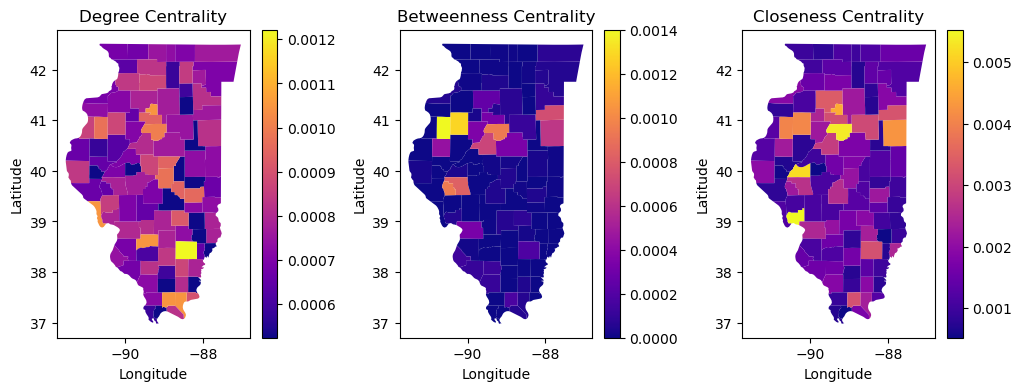

In [7]:
"""Plotting calculated centrality measures per county

   Plotting done using matplotlib's function sublots
   
   used counties gdp
"""
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.4)

# Create the first subplot for degree centrality
counties.plot(ax=axs[0],column='degree_centrality', cmap='plasma', legend=True)
axs[0].set_title('Degree Centrality')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Create the second subplot for betweenness centrality
counties.plot(ax=axs[1],column='betweenness_centrality', cmap='plasma', legend=True)
axs[1].set_title('Betweenness Centrality')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

# Create the third subplot for closeness centrality
counties.plot(ax=axs[2],column='closeness_centrality', cmap='plasma', legend=True)
axs[2].set_title('Closeness Centrality')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')

# Show the plot
plt.show()